In [330]:
import pandas as pd
from src.constants import OUTPUT_PATH
import os
import seaborn as sns
from matplotlib import pyplot as plt

USER = os.environ["USER"]
PROJECT_HOME = f"/home/{USER}/projects/feedback-DT"

In [331]:
def get_experiments(output_path, dir):
    settings = dir.split("-")[5:]
    dfs = []
    for seed_dir in os.listdir(os.path.join(output_path, dir)):
        exp_path = os.path.join(output_path, os.path.join(dir, seed_dir))
        try:
            df = pd.read_pickle(os.path.join(exp_path, "results.pkl"))
            df["seed"] = seed_dir
        except:
            continue
        for s in settings:
            param = s.split("_")[:-1]
            param ="_".join(param)
            value = s.split("_")[-1]
            value = int(value) if value.isnumeric() else (True if value == "True" else (False if value == "False" else value))
            df[param] = value
        try:
            df["feedback"] = df.apply(lambda row: "no" if row["use_feedback"] == False else row["feedback_mode"], axis=1)
            df["mission"] = df.apply(lambda row: "no" if row["use_mission"] == False else "yes", axis=1)
            df["rtg"] = df.apply(lambda row: "no" if row["use_rtg"] == False else "yes", axis=1)
            df["conditioning"] = "mission" + "_" + df["mission"] + "_" + "feedback" + "_" + df["feedback"] + "_" + "rtg" + "_" + df["rtg"]
        except KeyError:
            pass
        try:
            df["random"] = df.apply(lambda row: "random" + "_" + row["random_mode"] if row["feedback_mode"] == "random" else "random_no", axis=1)
            df["conditioning"] = df["conditioning"] + "_" + df["random"]
        except KeyError:
            pass
        try:
            df["num_eps"] = df["eps_per_seed"] * df["num_train_seeds"]
        except KeyError:
            pass
        try:
            df["eps_per_seed_num_train_seeds"] = df["eps_per_seed"].astype(str) + "_" + df["num_train_seeds"].astype(str)
        except KeyError:
            pass
        try:
            df["inference"] = "mission" + "_" + df["mission_at_inference"]
        except KeyError:
            try:
                df["inference"] = "feedback" + "_" + df["feedback_at_inference"]
            except:
                pass
        dfs.append(df)
    return dfs

def get_combined_df(output_path):
    dfs = []
    for dir in os.listdir(output_path):
        if "level" in dir:
            current_dfs = get_experiments(output_path, dir)
            dfs.extend(current_dfs)
    dfs = [df[(df["eval_type"] != "efficiency") & (df["model"] == "DT")] for df in dfs]
    comb_df = pd.concat(dfs, ignore_index=True)
    return comb_df

In [332]:
def plot_iid(level, level_df, param, metric, output_path):
    iid_df = level_df[level_df["eval_type"] == "iid_generalisation"]
    result = iid_df.groupby([param])[metric].aggregate('mean').reset_index().sort_values(metric, ascending=False)
    plt.figure()        
    ax1 = sns.barplot(x=param, y=metric, data=iid_df, order=result[param])
    plt.xticks(rotation=90)
    plt.title(f"IID generalisation on {level}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path,f"iid_generalisation_{level}_{param}_{metric}.png"))
    plt.show()
    print("SAVED FIG")

def plot_ood(level, level_df, param, metric, output_path):
    # ood_df = level_df[level_df["eval_type"] == "ood_generalisation"][[param, metric, "ood_type"]].groupby([param, "ood_type"]).mean().reset_index()
    ood_df = level_df[level_df["eval_type"] == "ood_generalisation"]
    result = ood_df.groupby([param])[metric].aggregate('mean').reset_index().sort_values(metric, ascending=False)
    plt.figure()
    ax = sns.barplot(x=param, y=metric, hue="ood_type", data=ood_df, order=result[param])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.title(f"OOD generalisation on {level}")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path,f"ood_generalisation_{level}_{param}_{metric}.png"))
    plt.show()
    print("SAVED FIG")

def plot_levels(output_path, params, metric, comb_df):
    for level in comb_df["level"].unique():
        level_df = comb_df[comb_df["level"] == level]
        for param in params:
            plot_iid(level, level_df, param, metric, output_path)
            plot_ood(level, level_df, param, metric, output_path)

In [333]:
def make_table_ood_type(ood_df, level, param, metric, output_path):
    results = ood_df[[param, "ood_type", metric]].groupby([param, "ood_type"]).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values(["ood_type", "Mean"], ascending=False)
    path = os.path.join(output_path,f"ood_generalisation_{level}_{param}_'ood_type'_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")

def make_table_seeds(df, param, metric):
    results = df[[param, "seed", metric]].groupby([param, "seed"]).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values(["seed", "Mean"], ascending=False)
    print("Results by seed")
    display(results)

def make_table_iid(level, level_df, param, metric, output_path):
    iid_df = level_df[level_df["eval_type"] == "iid_generalisation"]
    results = iid_df[[param, metric]].groupby(param).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
    path = os.path.join(output_path,f"iid_generalisation_{level}_{param}_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")
    make_table_seeds(iid_df, param, metric)

def make_table_ood(level, level_df, param, metric, output_path):
    ood_df = level_df[level_df["eval_type"] == "ood_generalisation"]
    results = ood_df[[param, metric]].groupby(param).agg(Mean=(metric, 'mean'), Std=(metric, 'std'), Min=(metric, 'min'), Max=(metric, 'max')).sort_values("Mean", ascending=False)
    path = os.path.join(output_path,f"ood_generalisation_{level}_{param}_{metric}.csv")
    results.to_csv(path)
    display(results)
    print("CREATED TABLE IN CSV")
    make_table_ood_type(ood_df, level, param, metric, output_path)
    make_table_seeds(ood_df, param, metric)

def make_tables(output_path, params, metric, comb_df):
    for level in comb_df["level"].unique():
        level_df = comb_df[comb_df["level"] == level]
        for param in params:
            make_table_iid(level, level_df, param, metric, output_path)
            make_table_ood(level, level_df, param, metric, output_path)

In [334]:
# Experiment names should correspond to the folder name
# Params should correspond to existing parameters (as tested), unless they're explicitly defined in the
# get_experiments function
EXPERIMENTS = {
    "random_start_or_from_end": ["randomise_starts"], 
    # "num_seeds_vs_eps_per_seed": ["eps_per_seed_num_train_seeds", "num_eps"], 
    # "loss_mean": ["loss_mean_type"],
    # "ep_distribution": ["ep_dist"],
    # "mission_at_inference": ["inference"],
    # "feedback_at_inference": ["inference"],
    # "random_feedback": ["conditioning"],
    # "random_mission": ["conditioning_with_random"],
    # "conditioning": ["conditioning"],
    # "only_mission": ["conditioning"],
    # "only_feedback": ["conditioning"],

}

METRICS = {
    "gc_success",
    # "success",
    # "pw_success",
    # "return",
    # "episode_length"
}

2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_100-num_train_seeds_128
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_1-num_train_seeds_1280
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_100-num_train_seeds_12
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_10-num_train_seeds_1280
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_1-num_train_seeds_128
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_10-num_train_seeds_128
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_100-num_train_seeds_1280
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_1-num_train_seeds_12
ood_generalisation_PutNextLocal_eps_per_seed_num_train_seeds_gc_success.png
ood_generalisation_PutNextLocal_num_eps_gc_success.png
iid_generalisation_PutNextLocal_num_eps_gc_success.png
iid_generalisation_PutNextLocal_eps_per_seed_num_train_seeds_gc_success.png
2023-09-23-07:38:03-level_putnextlocal-eps_per_seed_10-num_train_seeds_12


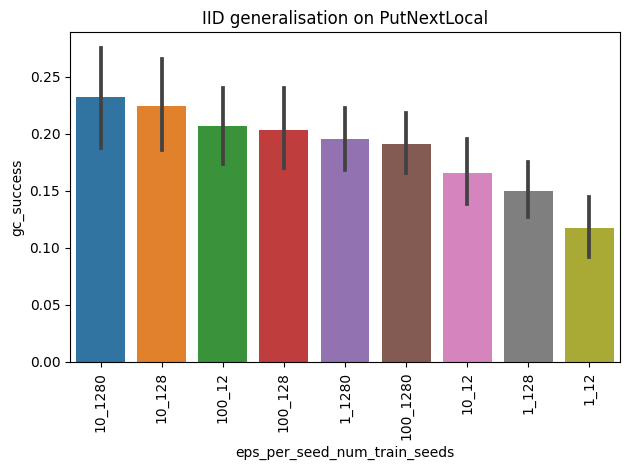

SAVED FIG


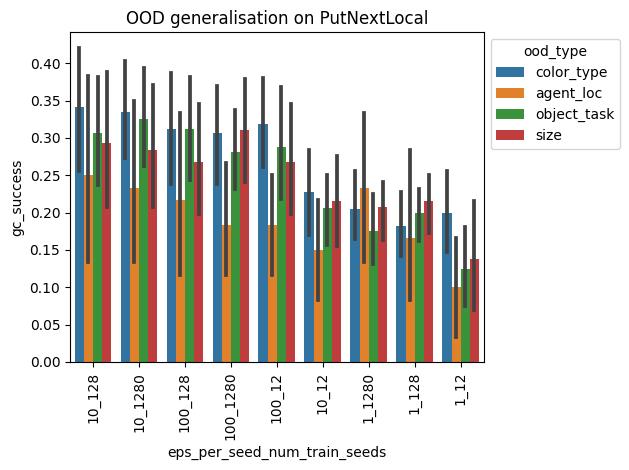

SAVED FIG


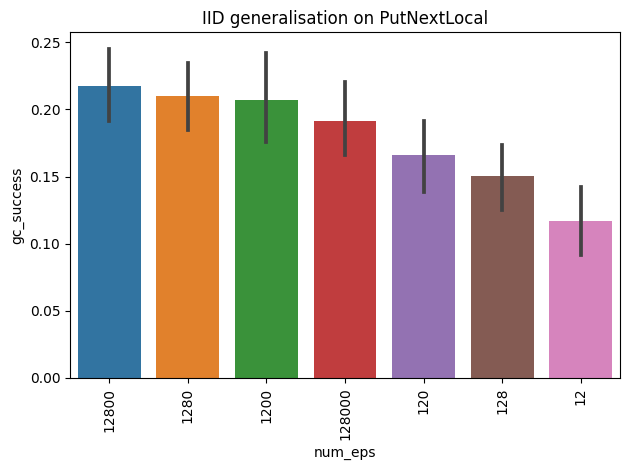

SAVED FIG


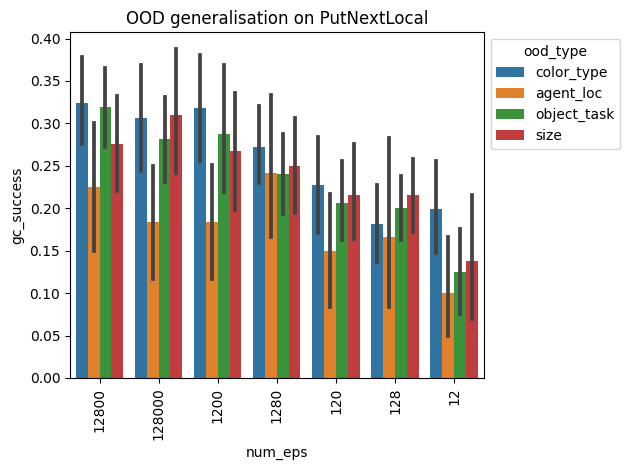

SAVED FIG


,Mean,Std,Min,Max
eps_per_seed_num_train_seeds,,,,
10_1280,0.232422,0.243384,0.0,0.75
10_128,0.224609,0.242688,0.0,0.75
100_12,0.207031,0.193673,0.0,0.75
100_128,0.203125,0.202713,0.0,0.75
1_1280,0.195312,0.165824,0.0,0.75
100_1280,0.191406,0.158376,0.0,0.75
10_12,0.166016,0.157732,0.0,0.75
1_128,0.150391,0.141490,0.0,0.75
1_12,0.117188,0.150254,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
eps_per_seed_num_train_seeds,seed,,,,
10_1280,1234567890,0.232422,0.243384,0.0,0.75
10_128,1234567890,0.224609,0.242688,0.0,0.75
100_12,1234567890,0.207031,0.193673,0.0,0.75
100_128,1234567890,0.203125,0.202713,0.0,0.75
1_1280,1234567890,0.195312,0.165824,0.0,0.75
100_1280,1234567890,0.191406,0.158376,0.0,0.75
10_12,1234567890,0.166016,0.157732,0.0,0.75
1_128,1234567890,0.150391,0.141490,0.0,0.75
1_12,1234567890,0.117188,0.150254,0.0,0.75


,Mean,Std,Min,Max
eps_per_seed_num_train_seeds,,,,
10_128,0.308594,0.263390,0.0,0.75
10_1280,0.308594,0.220692,0.0,1.00
100_128,0.291016,0.230066,0.0,0.75
100_1280,0.285156,0.197759,0.0,0.75
100_12,0.281250,0.217357,0.0,0.75
10_12,0.208984,0.168298,0.0,0.75
1_1280,0.199219,0.161072,0.0,0.75
1_128,0.193359,0.137522,0.0,0.75
1_12,0.150391,0.186503,0.0,0.75


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
eps_per_seed_num_train_seeds,ood_type,,,,
100_1280,size,0.310345,0.207614,0.0,0.75
10_128,size,0.293103,0.276045,0.0,0.75
10_1280,size,0.284483,0.218805,0.0,0.75
100_12,size,0.267241,0.199676,0.0,0.75
100_128,size,0.267241,0.199676,0.0,0.75
10_12,size,0.215517,0.159857,0.0,0.75
1_128,size,0.215517,0.110278,0.0,0.50
1_1280,size,0.206897,0.117050,0.0,0.50
1_12,size,0.137931,0.206871,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
eps_per_seed_num_train_seeds,seed,,,,
10_128,1234567890,0.308594,0.263390,0.0,0.75
10_1280,1234567890,0.308594,0.220692,0.0,1.00
100_128,1234567890,0.291016,0.230066,0.0,0.75
100_1280,1234567890,0.285156,0.197759,0.0,0.75
100_12,1234567890,0.281250,0.217357,0.0,0.75
10_12,1234567890,0.208984,0.168298,0.0,0.75
1_1280,1234567890,0.199219,0.161072,0.0,0.75
1_128,1234567890,0.193359,0.137522,0.0,0.75
1_12,1234567890,0.150391,0.186503,0.0,0.75


,Mean,Std,Min,Max
num_eps,,,,
12800,0.217773,0.224015,0.0,0.75
1280,0.209961,0.207951,0.0,0.75
1200,0.207031,0.193673,0.0,0.75
128000,0.191406,0.158376,0.0,0.75
120,0.166016,0.157732,0.0,0.75
128,0.150391,0.141490,0.0,0.75
12,0.117188,0.150254,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
num_eps,seed,,,,
12800,1234567890,0.217773,0.224015,0.0,0.75
1280,1234567890,0.209961,0.207951,0.0,0.75
1200,1234567890,0.207031,0.193673,0.0,0.75
128000,1234567890,0.191406,0.158376,0.0,0.75
120,1234567890,0.166016,0.157732,0.0,0.75
128,1234567890,0.150391,0.141490,0.0,0.75
12,1234567890,0.117188,0.150254,0.0,0.75


,Mean,Std,Min,Max
num_eps,,,,
12800,0.299805,0.225158,0.0,1.00
128000,0.285156,0.197759,0.0,0.75
1200,0.281250,0.217357,0.0,0.75
1280,0.253906,0.224666,0.0,0.75
120,0.208984,0.168298,0.0,0.75
128,0.193359,0.137522,0.0,0.75
12,0.150391,0.186503,0.0,0.75


CREATED TABLE IN CSV


,,Mean,Std,Min,Max
num_eps,ood_type,,,,
128000,size,0.310345,0.207614,0.0,0.75
12800,size,0.275862,0.207796,0.0,0.75
1200,size,0.267241,0.199676,0.0,0.75
1280,size,0.250000,0.214599,0.0,0.75
120,size,0.215517,0.159857,0.0,0.75
128,size,0.215517,0.110278,0.0,0.50
12,size,0.137931,0.206871,0.0,0.75
12800,object_task,0.318750,0.221384,0.0,1.00
1200,object_task,0.287500,0.250320,0.0,0.75


CREATED TABLE IN CSV
Results by seed


,,Mean,Std,Min,Max
num_eps,seed,,,,
12800,1234567890,0.299805,0.225158,0.0,1.00
128000,1234567890,0.285156,0.197759,0.0,0.75
1200,1234567890,0.281250,0.217357,0.0,0.75
1280,1234567890,0.253906,0.224666,0.0,0.75
120,1234567890,0.208984,0.168298,0.0,0.75
128,1234567890,0.193359,0.137522,0.0,0.75
12,1234567890,0.150391,0.186503,0.0,0.75


In [335]:
for experiment in EXPERIMENTS.keys():
    DATA_HOME = f"{PROJECT_HOME}/data/{experiment}"
    OUTPUT = f"{DATA_HOME}/output"
    comb_df = get_combined_df(OUTPUT)
    for metric in METRICS:
        plot_levels(OUTPUT, EXPERIMENTS[experiment], metric, comb_df)
        make_tables(OUTPUT, EXPERIMENTS[experiment], metric, comb_df)